In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Enable inline plotting at lower left
%matplotlib inline

In [2]:
import pynrc
from pynrc import nrc_utils

from pynrc.maths.image_manip import fourier_imshift, fshift
from pynrc.maths.coords import rtheta_to_xy

from astropy.io import fits

# Progress bar
from tqdm.auto import tqdm, trange

# Disable informational messages and only include warnings and higher
pynrc.setup_logging(level='WARN')

pyNRC log messages of level WARN and above will be shown.
pyNRC log outputs will be directed to the screen.


In [3]:
# Define 2MASS Ks bandpass and source information
bp_k = pynrc.bp_2mass('k')

# Solar analog at 10pc
# https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf#apjsaabfdft3

# Science      source,  dist, age, sptype, Teff, [Fe/H], log_g, mag, band
args_sources = [('G2V', 10.0, 100,  'G2V', 5777, 0, 4.43, 3.27, bp_k)]

# References     source,  sptype, Teff, [Fe/H], log_g, mag, band
ref_sources = [('G2V Ref', 'G2V', 5777, 0, 4.43, 3.27, bp_k)]

In [4]:
i=0

# Get science spectrum
name_sci, dist_sci, age, spt_sci, Teff_sci, feh_sci, logg_sci, mag_sci, bp_sci = args_sources[i]
args = (spt_sci, mag_sci, 'vegamag', bp_sci)
kwargs = {'Teff':Teff_sci, 'metallicity':feh_sci, 'log_g':logg_sci}
sp_sci = pynrc.stellar_spectrum(*args, **kwargs)
sp_sci.name = name_sci

# Do the same for the reference source
name_ref, spt_ref, Teff_ref, feh_ref, logg_ref, mag_ref, bp_ref = ref_sources[i]
args = (spt_ref, mag_ref, 'vegamag', bp_ref)
kwargs = {'Teff':Teff_ref, 'metallicity':feh_ref, 'log_g':logg_ref}
sp_ref = pynrc.stellar_spectrum(*args, **kwargs)
sp_ref.name = name_ref

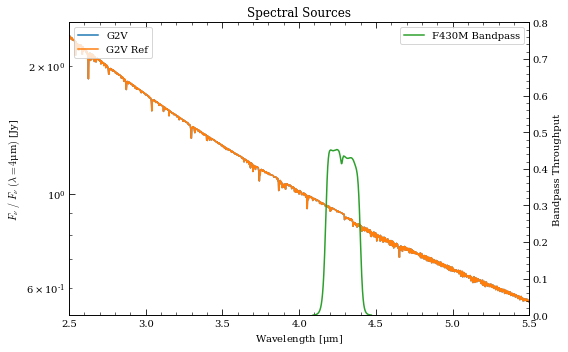

In [5]:
# Plot the two spectra
fig, ax = plt.subplots(1,1, figsize=(8,5))

xr = [2.5,5.5]

for sp in [sp_sci, sp_ref]:
    w = sp.wave / 1e4
    ind = (w>=xr[0]) & (w<=xr[1])
    sp.convert('Jy')
    f = sp.flux / np.interp(4.0, w, sp.flux)
    ax.semilogy(w[ind], f[ind], lw=1.5, label=sp.name)
    ax.set_ylabel(r'$F_{\nu}~/~F_{\nu}~(\lambda=4\mathdefault{\mu m})$ [Jy]')
    sp.convert('flam')

ax.set_xlim(xr)
ax.set_xlabel(r'Wavelength [$\mathdefault{\mu m}$]')
ax.set_title('Spectral Sources')

# Overplot Filter Bandpass
bp = pynrc.read_filter('F430M', pupil='CIRCLYOT', mask='MASK430R')
ax2 = ax.twinx()
ax2.plot(bp.wave/1e4, bp.throughput, color='C2', label=bp.name+' Bandpass')
ax2.set_ylim([0,0.8])
ax2.set_xlim(xr)
ax2.set_ylabel('Bandpass Throughput')

ax.legend(loc='upper left')
ax2.legend(loc='upper right')

fig.tight_layout()

In [7]:
bp = pynrc.read_filter('F430M')
obs = nrc_utils.S.Observation(sp_sci, bp, binset=bp.wave)
print(obs.effstim('counts')) 
print(obs.effstim('vegamag'))

95219479.90915118
3.2607771199515287


# Observation Configs

In [8]:
# Define detector configuration and PSF simulation
filt, mask, pupil = ('F430M', 'MASK430R', 'CIRCLYOT')
wind_mode, subsize = ('WINDOW', 320)
fov_pix, oversample = (160, 2)

# Science configuration
nrc_sci = pynrc.NIRCam(filter=filt, image_mask=mask, pupil_mask=pupil,
                       wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                       fov_pix=fov_pix, oversample=oversample)

# Reference configuration
nrc_ref = pynrc.NIRCam(filter=filt, image_mask=mask, pupil_mask=pupil,
                       wind_mode=wind_mode, xpix=subsize, ypix=subsize, 
                       fov_pix=fov_pix, oversample=oversample)

In [9]:
# Turn off jitter components
nrc_sci.options['jitter'] = None
nrc_sci.options['jitter_sigma'] = 0

nrc_ref.options['jitter'] = None
nrc_ref.options['jitter_sigma'] = 0

In [10]:
# Update both the science and reference observations
# Shooting for ~3600 sec of acquisition time
nrc_sci.update_detectors(read_mode='MEDIUM8', ngroup=7, nint=50, verbose=True)
nrc_ref.update_detectors(read_mode='MEDIUM8', ngroup=7, nint=50, verbose=False)

New Ramp Settings
  read_mode  :  MEDIUM8
  nf         :        8
  nd2        :        2
  ngroup     :        7
  nint       :       50
New Detector Settings
  wind_mode  :   WINDOW
  xpix       :      320
  ypix       :      320
  x0         :        0
  y0         :        0
New Ramp Times
  t_group    :   10.690
  t_frame    :    1.069
  t_int      :   72.695
  t_int_tot1 :   73.784
  t_int_tot2 :   73.784
  t_exp      : 3634.736
  t_acq      : 3689.184


# OPD Configuration

In [11]:
from webbpsf_ext.opds import OPDFile_to_HDUList

nrc_sci.opd_list[0]
opd_hdul_orig = OPDFile_to_HDUList(nrc_sci.opd_list[0], slice=5)

In [12]:
opd_dir = 'NIRCAM_OPDS/'

hdul_opds_static = OPDFile_to_HDUList(opd_dir + 'STATIC_NIRCAM-A_INPUT.fits')
hdul_opds_static[0].data = hdul_opds_static[0].data * 1e6
hdul_opds_static[0].header['BUNIT'] = 'micron'

In [13]:
def plot_im(im, fig, ax, vlim=None, add_cbar=True, return_ax=False, 
    extent=None, cmap='RdBu_r', **kwargs):
    """
    Plot single image on some axes
    """
    
    if vlim is None:
        vlim = np.max(np.abs(im))
        
    img = ax.imshow(im, cmap=cmap, vmin=-1*vlim, vmax=+1*vlim, extent=extent)
    
    # Add colorbar
    if add_cbar:
        cbar = fig.colorbar(img, ax=ax, **kwargs)
        cbar.set_label('Amplitude [nm]')

    if return_ax and add_cbar:
        return ax, cbar
    elif return_ax:
        return ax
    
def calc_rms(im):
    ind = (im != 0) & (np.isfinite(im))
    rms = np.sqrt((im[ind] ** 2).mean())
    return rms

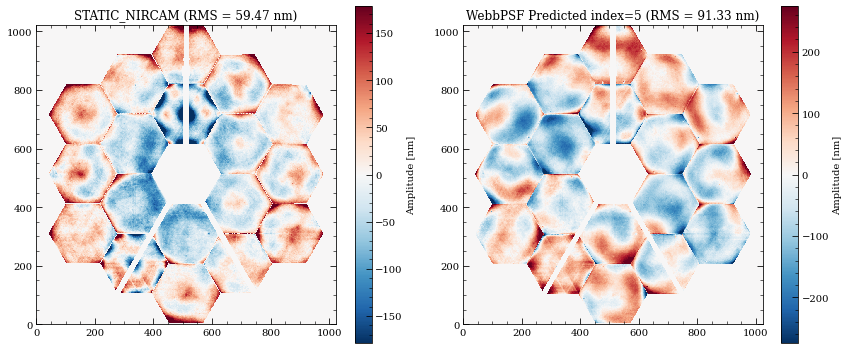

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

ax = axes[0]
opd = hdul_opds_static[0].data * 1000
rms_opd = calc_rms(opd)
vlim = 3*rms_opd
plot_im(opd, fig, ax, vlim=vlim)
ax.set_title("STATIC_NIRCAM (RMS = {:.2f} nm)".format(rms_opd))

ax = axes[1]
opd = opd_hdul_orig[0].data * 1000
rms_opd = calc_rms(opd)
vlim = 3*rms_opd
plot_im(opd, fig, ax, vlim=vlim)
ax.set_title("WebbPSF Predicted index=5 (RMS = {:.2f} nm)".format(rms_opd))

fig.tight_layout()

## Compare Resulting PSFs

In [15]:
nrc_sci.include_si_wfe = True
nrc_ref.include_si_wfe = True

nrc_sci.include_distortions = False
nrc_ref.include_distortions = False

In [16]:
data = opd_hdul_orig[0].data
np.median(data[data!=0]), np.max(data[data!=0]), np.std(data[data!=0])

(-0.0016620071, 0.65375507, 0.09132791)

In [17]:
data = hdul_opds_static[0].data
np.median(data[data!=0]), np.max(data[data!=0]), np.std(data[data!=0])

(0.0014409472071565687, 0.3592371588945389, 0.05946662573867137)

In [18]:
nrc_sci.pupilopd = hdul_opds_static
nrc_ref.pupilopd = opd_hdul_orig

In [19]:
res1_static = nrc_sci.calc_psf(sp=sp_sci) #, return_oversample=False, coord_vals=(0,0), coord_frame='idl')
res2_static = nrc_ref.calc_psf(sp=sp_sci) #, return_oversample=False, coord_vals=(0,0), coord_frame='idl')

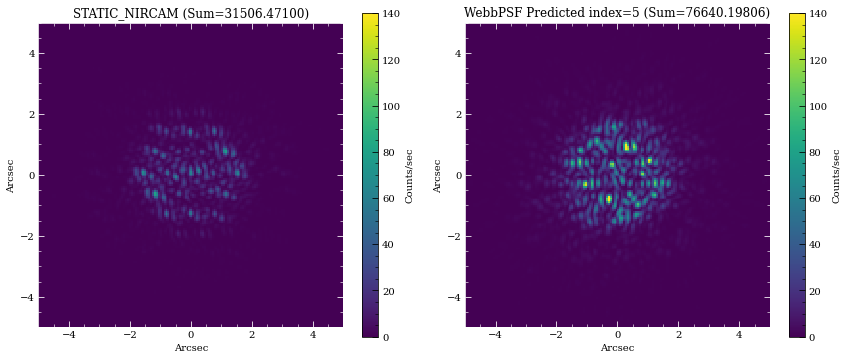

In [19]:
from pynrc.nb_funcs import plot_hdulist
from matplotlib.patches import Circle

fig, axes = plt.subplots(1,2, figsize=(12,5))
xylim = 5
xlim = ylim = np.array([-1,1])*xylim

titles = ['STATIC_NIRCAM', 'WebbPSF Predicted index=5']
for j, hdul in enumerate([res1_static, res2_static]):
    ax = axes[j]
    plot_hdulist(hdul, ext=1, ax=ax, xr=xlim, yr=ylim, vmin=0, vmax=140)
    
    tot =  hdul[0].data.sum()
    sum_str = f' (Sum={tot:.5f})'
    ax.set_title(titles[j] + sum_str)


fig.tight_layout()
#fig.subplots_adjust(top=0.85)


## Open WFE Drift Components

In [20]:
tvals_sec = fits.getdata(opd_dir + 'time_vector.fits') * 60

# Thermal, frill, and IEC
hdul_opds_thermal = fits.open(opd_dir + 'TD_NIRCAM.fits')
hdul_opds_frill   = fits.open(opd_dir + 'FRILLCO_NIRCAM.fits')
hdul_opds_iec     = fits.open(opd_dir + 'IEC_NIRCAM.fits')

for hdul in [hdul_opds_thermal, hdul_opds_frill, hdul_opds_iec]:
    for hdu in hdul:
        hdu.data *= 1e6
        hdu.header['BUNIT'] = 'micron'

In [21]:
# Add Requirements drifts to OTE OPDs
ind_case = 2 # Requirements scenario
dWFE = hdul_opds_thermal[ind_case].data[-1] + \
       hdul_opds_frill[ind_case].data[-1] + \
       hdul_opds_iec[ind_case].data[-1]

In [22]:
from copy import deepcopy

# Copy original OPDs
opd1 = deepcopy(hdul_opds_static)
opd2 = deepcopy(opd_hdul_orig)

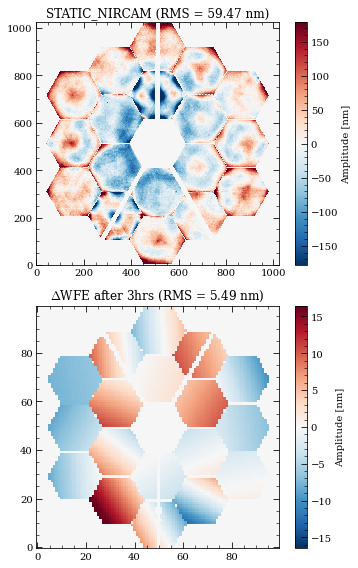

In [23]:
fig, axes = plt.subplots(2,1, figsize=(5,8))
axes = axes.flatten()

ax = axes[0]
opd = opd1[0].data * 1000
rms_opd = calc_rms(opd)
vlim = 3*rms_opd
plot_im(opd, fig, ax, vlim=vlim)
ax.set_title("STATIC_NIRCAM (RMS = {:.2f} nm)".format(rms_opd))

ax = axes[1]
opd = dWFE * 1000 # Amplitude in nm
rms_opd = calc_rms(opd)
vlim = 3*rms_opd
plot_im(opd, fig, ax, vlim=vlim)
ax.set_title("$\Delta$WFE after 3hrs (RMS = {:.2f} nm)".format(rms_opd))

fig.tight_layout()

In [24]:
from pynrc.nrc_utils import frebin

# Flip along y-axis
dWFE = dWFE[::-1,:]

# Rebin delta WFE
dWFE = frebin(dWFE, dimensions=1024, total=False)

# Add to OPDs
opd1[0].data += dWFE
opd2[0].data += dWFE

# Save to observation class
nrc_sci.pupilopd = opd1
nrc_ref.pupilopd = opd2

In [26]:
res1 = nrc_sci.calc_psf(sp=sp_sci)#, coord_vals=(0.007,0.007), coord_frame='idl')
res2 = nrc_ref.calc_psf(sp=sp_sci)#, coord_vals=(0.007,0.007), coord_frame='idl')

diff1 = deepcopy(res1)
diff2 = deepcopy(res2)

diff1[1].data -= res1_static[1].data
diff2[1].data -= res2_static[1].data

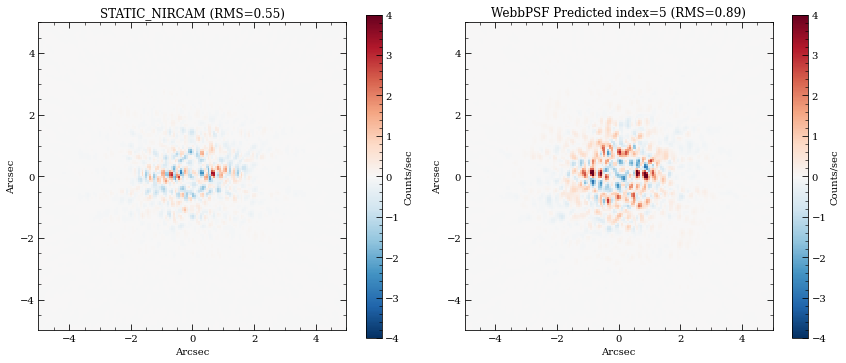

In [27]:
from pynrc.nb_funcs import plot_hdulist
from pynrc.nrc_utils import dist_image

fig, axes = plt.subplots(1,2, figsize=(12,5))
xylim = 5
xlim = ylim = np.array([-1,1])*xylim

titles = ['STATIC_NIRCAM', 'WebbPSF Predicted index=5']
for j, hdul in enumerate([diff1, diff2]):
    ax = axes[j]
    plot_hdulist(hdul, ext=1, ax=ax, xr=xlim, yr=ylim, vmin=-4, vmax=4, cmap='RdBu_r', axes_color='k')
    
    hdu = hdul[1]
    im_rho = dist_image(hdu.data, pixscale=hdu.header['PIXELSCL'])
    
    rms = np.std(hdu.data[im_rho<1.5])
    rms_str = f' (RMS={rms:.2f})'
    ax.set_title(titles[j] + rms_str)


fig.tight_layout()
#fig.subplots_adjust(top=0.85)


## Target Acquisition

In [28]:
# nrc_sci.pupilopd = hdul_opds_static
# nrc_ref.pupilopd = opd_hdul_orig

nrc_sci.pupilopd = opd1
nrc_ref.pupilopd = opd2

In [29]:
# Perform a 10 mas offset
r_off  = 0.010
th_off = 45

for nrc in [nrc_sci, nrc_ref]:
    nrc.options['source_offset_r'] = r_off
    nrc.options['source_offset_theta'] = th_off

# for nrc in [nrc_sci, nrc_ref]:
#     nrc.options['source_offset_r'] = 0
#     nrc.options['source_offset_theta'] = 0

res1 = nrc_sci.calc_psf(sp=sp_sci)#, coord_vals=(0.007,0.007), coord_frame='idl')
res2 = nrc_ref.calc_psf(sp=sp_sci)#, coord_vals=(0.007,0.007), coord_frame='idl')

for nrc in [nrc_sci, nrc_ref]:
    nrc.options['source_offset_r'] = 0
    nrc.options['source_offset_theta'] = 0


In [30]:
diff1 = deepcopy(res1)
diff2 = deepcopy(res2)

# Shift PSFs to center
for hdul in [diff1, diff2]:
    for hdu in hdul:
        pix_scale = hdu.header['PIXELSCL']
        r_pix = r_off / pix_scale
        xoff_pix, yoff_pix = rtheta_to_xy(r_pix, th_off)
        hdu.data = fshift(hdu.data, -1*xoff_pix, -1*yoff_pix, interp='cubic')

# Subtract perfectly centered PSF
for i in range(len(diff1)):
    diff1[i].data -= res1_static[i].data
    diff2[i].data -= res2_static[i].data

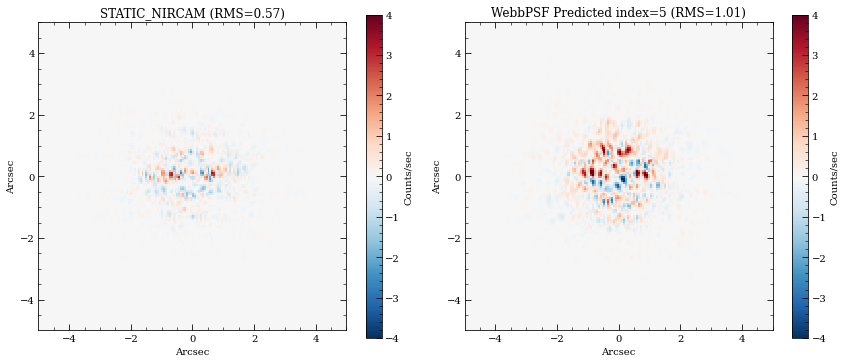

In [31]:
from pynrc.nb_funcs import plot_hdulist
from pynrc.nrc_utils import dist_image

fig, axes = plt.subplots(1,2, figsize=(12,5))
xylim = 5
xlim = ylim = np.array([-1,1])*xylim

titles = ['STATIC_NIRCAM', 'WebbPSF Predicted index=5']
for j, hdul in enumerate([diff1, diff2]):
    ax = axes[j]
    plot_hdulist(hdul, ext=1, ax=ax, xr=xlim, yr=ylim, vmin=-4, vmax=4, cmap='RdBu_r', axes_color='k')
    
    hdu = hdul[1]
    im_rho = dist_image(hdu.data, pixscale=hdu.header['PIXELSCL'])
    
    rms = np.std(hdu.data[im_rho<1.5])
    rms_str = f' (RMS={rms:.2f})'
    ax.set_title(titles[j] + rms_str)


fig.tight_layout()
#fig.subplots_adjust(top=0.85)
